# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [2]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [5]:
import geomstats.datasets.utils as data_utils
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, ClosedDiscreteCurves, L2CurvesMetric

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.pca import TangentPCA


We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [6]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]
cell_type = "dunn"
all_cell_types = ["dunn", "dlm8"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    lines_name = "lines"
    treatments_name = "mutations"

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Total number of cells : 650
['control' 'cytd' 'jasp']
['dlm8' 'dunn']
Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230514_04:56:43


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [7]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


In [8]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

In [9]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

In [10]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

In [11]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

In [12]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


In [13]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [14]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

In [15]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)
(204, 200, 2)


In [16]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 200, 2)


# Remove the other type of cells (dlm8 or dunn)


In [17]:
def remove_cells(cells, cell_shapes, lines, treatments, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, lines, treatments,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    treatments = list(np.delete(np.array(treatments), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, lines, treatments

In [18]:
# Find all cells of the other type
remove_indices = []
remove_cell_type = copy.deepcopy(all_cell_types)
remove_cell_type.remove(cell_type)
remove_cell_type = remove_cell_type[0]
for i in range(len(lines)):
    if lines[i] == remove_cell_type:
        remove_indices.append(i)

# Delete all cells of the other type
cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, remove_indices)

## Remove outliers by DeCOr-MDS using linear metric

In [19]:
""" 
Only remove abnormal cells
"""
if cell_type == "dunn":
    abnormal_outlier_indices = [89]
    cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, abnormal_outlier_indices)

In [20]:
lines_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(lines))}
treatments_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(treatments))}

print(f"Dictionary associated to label \"{lines_name}\":")
print(lines_dict)
print(f"Dictionary associated to label \"{treatments_name}\":")
print(treatments_dict)

Dictionary associated to label "lines":
{'dunn': 0}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [28]:
R2 = Euclidean(dim=2)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2, k_sampling_points=200)
CURVES_SPACE_SRV = DiscreteCurves(R2, k_sampling_points=200)

SRV_METRIC = CURVES_SPACE_SRV.metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2CurvesMetric
METRICS["SRV"] = SRV_METRIC

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [13]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

In [14]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [41]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [43]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cell_shapes]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cell_shapes
]


In [44]:
dists_summary = pd.DataFrame(
    data={
        lines_name: lines,
        treatments_name: treatments,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

In [45]:
dists_summary.head()

,lines,mutations,Linear,SRV
0,dunn,control,0.001144,0.004242
1,dunn,control,0.001390,0.004319
2,dunn,control,0.002194,0.005906
3,dunn,control,0.001118,0.003754
4,dunn,control,0.002810,0.007085


# Dimension reduction

## Dimension redunction using tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [24]:
cells_flat = gs.reshape(cell_shapes, (len(cells), -1))

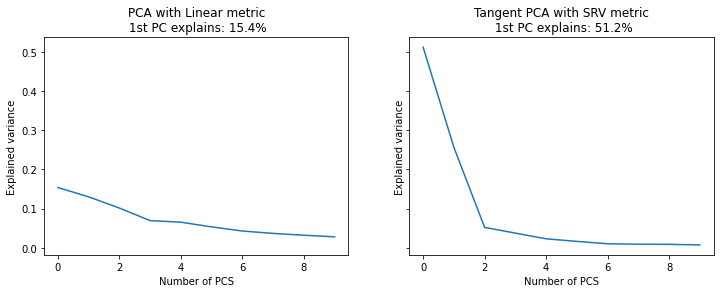

In [29]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    first_pc_explains = 100*sum(pcas[metric_name].explained_variance_ratio_[:1])
    axs[i].set_title(f"{tangent}PCA with {metric_name} metric\n 1st PC explains: {first_pc_explains:.1f}%")

SAVEFIG = True
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_explained_variance.svg"))

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [30]:
sum(pcas["Linear"].explained_variance_ratio_[:1])

0.15396625417070087

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [31]:
sum(pcas["SRV"].explained_variance_ratio_[:1])

0.5122643035240595

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

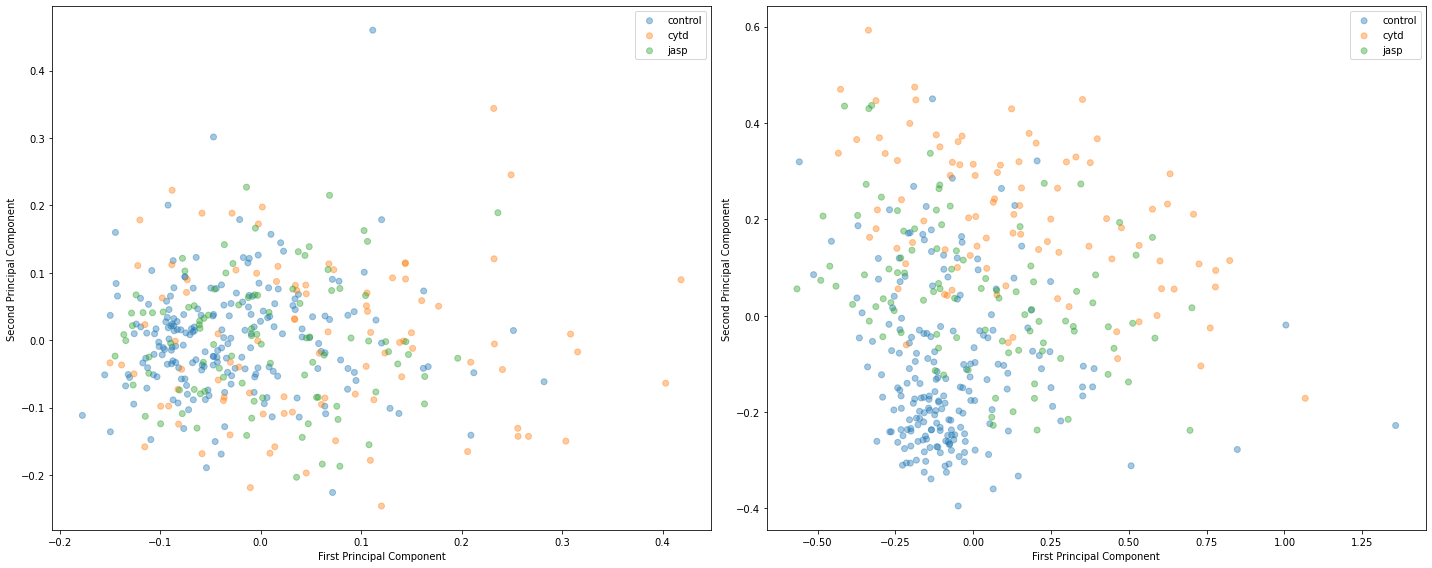

In [61]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [treatments_dict], [treatments], [treatments_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i].set_xlabel("First Principal Component")
            axs[i].set_ylabel("Second Principal Component")
            # axs[i].set_title(
            #     f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_projections_2d.pdf"))

## Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [66]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points
 
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists


In [67]:
pairwise_dists = parallel_dist(cell_shapes, dist_fun=linear_dist)

INFO: finding looplift candidates


TypeError: dist() missing 1 required positional argument: 'point_b'

In [38]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)

### Plot in 2D

In [64]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_
# Goodness-of-fit statistic used in MDS
print("the stress for Linear model is:", mds["Linear"].stress_)

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds["SRV"].stress_)


the stress for Linear model is: 1.5418546589584812e-05
the stress for SRV model is: 0.00012059803266577726


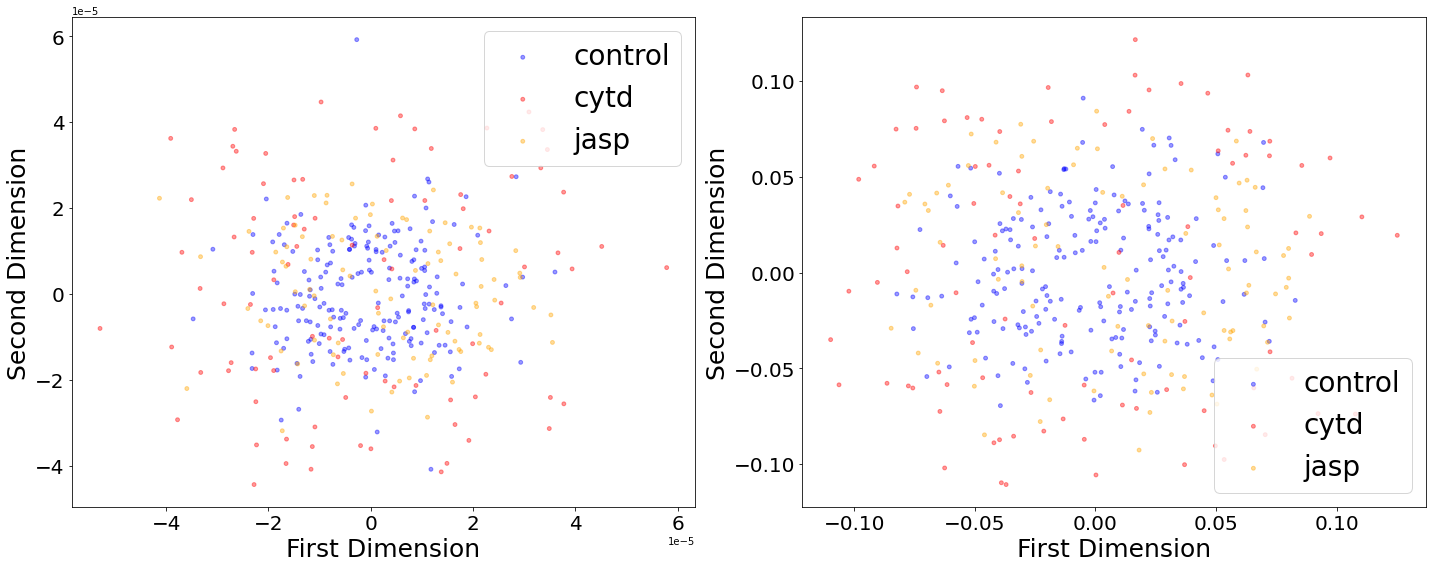

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

color_encoding = {"control": "blue", "cytd": "red", "jasp": "orange"}

title_nums = ['(a)', '(b)']


for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [treatments_dict], [treatments], [treatments_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            axs[i].tick_params(axis="x", labelsize=20) 
            axs[i].tick_params(axis="y", labelsize=20) 
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i].scatter(
                position[:, 0],
                position[:, 1],
                c=[color_encoding[label] for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i].set_xlabel("First Dimension", fontsize=25)
            axs[i].set_ylabel("Second Dimension", fontsize=25)
            # axs[i].tick_params(axis='both', which='major', size=15)
            # axs[i].set_title(
            #     f"{title_nums[i]} Projections for MDS with {metric_name} metric \n")
            axs[i].legend(fontsize=28)

plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_mds_projections_2d.pdf"))

In [48]:
""" 
Calculates the Silhouette Score
"""
for i, metric_name in enumerate(["Linear", "SRV"]):
    position = pos[metric_name]
    print("position shape is:", position.shape)
    print("label_b length is:", len(labels_b))
    score = calinski_harabasz_score(position, labels_b)
    print(f"silhouette score for {metric_name} of dimension 2 is:", score)

position shape is: (391, 2)


NameError: name 'labels_b' is not defined

### Plot in 3D

In [50]:
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [51]:
mds = {}
pos = {}

n_components = 3

mds["Linear"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_
print("the stress for Linear model is:", mds["Linear"].stress_)


mds["SRV"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds["SRV"].stress_)


the stress for Linear model is: 0.779578489264852
the stress for SRV model is: 0.011968970285861389


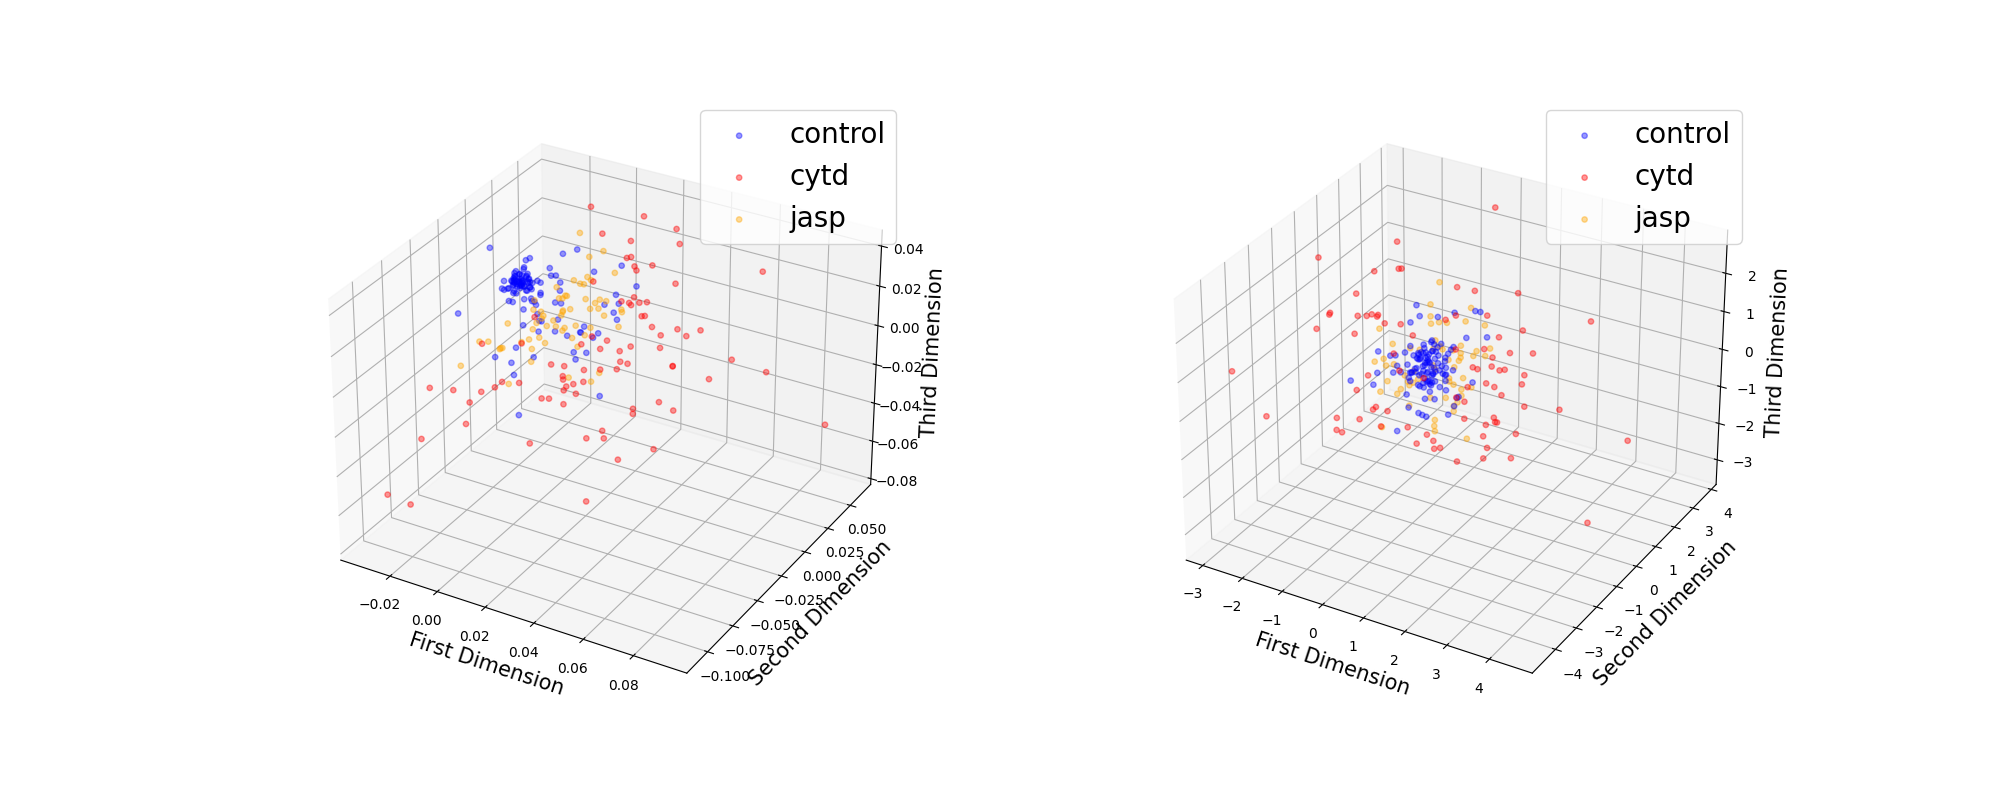

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), subplot_kw=dict(projection='3d'))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_b_dict], [labels_b], [labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axes[i].scatter(
                position[:, 0],
                position[:, 1],
                position[:, 2],
                c=[color_encoding[label] for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axes[i].set_xlabel("First Dimension", fontsize=15)
            axes[i].set_ylabel("Second Dimension", fontsize=15)
            axes[i].set_zlabel("Third Dimension", fontsize=15)
            # axes[i].set_title(
            #     f"{title_nums[i]} Projections for MDS with \n {metric_name} metric \n")
            axes[i].legend(fontsize = 20)

if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_mds_projections_3d.pdf"))

In [53]:
""" 
Calculates the Silhouette Score
"""
for i, metric_name in enumerate(["Linear", "SRV"]):
    position = pos[metric_name]
    print("position shape is:", position.shape)
    print("label_b length is:", len(labels_b))
    score = calinski_harabasz_score(position, labels_b)
    print(f"silhouette score for {metric_name} of dimension 3 is:", score)

position shape is: (258, 3)
label_b length is: 258
silhouette score for Linear of dimension 3 is: 24.329015563149305
position shape is: (258, 3)
label_b length is: 258
silhouette score for SRV of dimension 3 is: 0.7118260726999687


### Plot stress vs dimension for Linear and SRV

In [49]:
mds = {}
pos = {}

n_components_list = range(2, 10)
linear_stress_list = []
srv_stress_list = []

for n_components in n_components_list:
    mds["Linear"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
    pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_
    linear_stress = mds["Linear"].stress_
    linear_stress_list.append(linear_stress)
    print(f"the stress for Linear model for dimension {n_components} is: {linear_stress}")

    mds["SRV"] = manifold.MDS(n_components=n_components, random_state=1, dissimilarity="precomputed")
    pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_
    srv_stress = mds["SRV"].stress_
    srv_stress_list.append(srv_stress)
    print(f"the stress for SRV model for dimension {n_components} is:, {srv_stress}")



the stress for Linear model for dimension 2 is: 1.5418546589584812e-05
the stress for SRV model for dimension 2 is:, 0.00012059803266577726
the stress for Linear model for dimension 3 is: 1.004984045601824e-05
the stress for SRV model for dimension 3 is:, 7.587244079120555e-05
the stress for Linear model for dimension 4 is: 7.570861352514012e-06
the stress for SRV model for dimension 4 is:, 5.4528032347395335e-05
the stress for Linear model for dimension 5 is: 6.379065317663343e-06
the stress for SRV model for dimension 5 is:, 4.3091511224579716e-05
the stress for Linear model for dimension 6 is: 5.3619640448944745e-06
the stress for SRV model for dimension 6 is:, 3.486824874386444e-05
the stress for Linear model for dimension 7 is: 4.866796021815388e-06
the stress for SRV model for dimension 7 is:, 3.0187599952925035e-05
the stress for Linear model for dimension 8 is: 4.3632488676329195e-06
the stress for SRV model for dimension 8 is:, 2.5996815323849084e-05
the stress for Linear mode

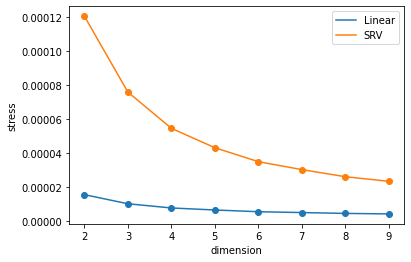

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure()
plt.scatter(n_components_list, linear_stress_list)
plt.plot(n_components_list, linear_stress_list, label='Linear')
plt.scatter(n_components_list, srv_stress_list)
plt.plot(n_components_list, srv_stress_list, label='SRV')
plt.xlabel("dimension")
plt.ylabel("stress")
plt.legend()
plt.show()

if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_mds_stress.pdf"))

### Use DeCOr-MDS to infer the dimension

In [37]:
from nsimplices import *

dim_start = 2
dim_end = 10
feature_num = 10
outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_srv_dists, feature_num, dim_start, dim_end, std_multi=2)
print(subspace_dim)

3
